In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests


# 1 Pre processing

In [6]:
nasdaq=pd.read_csv('data/NASDAQ_100_MCap.csv')
hs300=pd.read_csv('data/HS300.csv')

In [14]:
def split(df,start,end):
    
    df.date=pd.to_datetime(df.date,dayfirst=True).astype(str)
    df.date=df.date.str.replace('-','').astype(str)
    df.date=df.date.str.replace("\''","").astype(str)
    df=df.set_index('date')
    
    df_r=(np.log(df)-np.log(df.shift(1))).fillna(method='bfill')
    
    df_r=df_r.loc[start:end]
    
    subset_ls=df_r.columns.values.tolist()
    df_r=df_r.drop_duplicates(subset=subset_ls,keep='first')
    
    df_r=df_r.replace(0,np.nan).dropna(how='all',axis=0).replace(np.nan,0)
    
    index_df=df.loc[df_r.index].mean(axis=1)
    
    return df_r,index_df
                                

In [18]:
nasdaq_df,nasdaq_index_df=split(nasdaq,'2015-01-05','2020-01-01')
hs300_df,hs300_index_df=split(hs300,'2015-01-05','2020-01-01')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0.5, 1.0, 'NASDAQ')

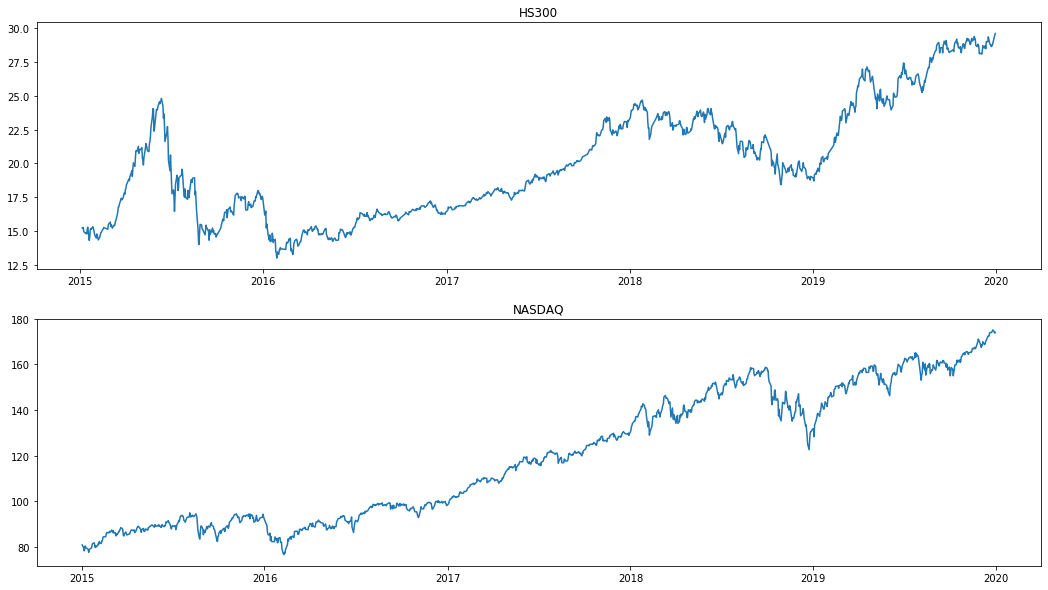

In [19]:
fig,ax=plt.subplots(2,1,figsize=(18,10))

ax[0].plot(pd.to_datetime(hs300_index_df.index),hs300_index_df.values)
ax[0].set_title('HS300')

ax[1].plot(pd.to_datetime(nasdaq_index_df.index),nasdaq_index_df.values)
ax[1].set_title('NASDAQ')

In [21]:
df = pd.merge(pd.DataFrame(nasdaq_df.mean(axis=1),columns=['NASDAQ']),pd.DataFrame(hs300_df.mean(axis=1),columns=['HS300']),on='date')

In [22]:
df

,NASDAQ,HS300
date,,
20150105,-0.014914,0.030368
20150106,-0.014338,0.002934
20150107,0.012549,0.004967
20150108,0.018089,-0.019711
20150109,-0.006305,-0.004833
...,...,...
20191224,0.001414,0.007507
20191226,0.000919,0.008929
20191227,-0.002728,-0.001726


In [23]:
df['NASDAQ_Y']=df['NASDAQ'].shift(-1)
df['HS300_Y']=df['HS300'].shift(-1)

In [24]:
df

,NASDAQ,HS300,NASDAQ_Y,HS300_Y
date,,,,
20150105,-0.014914,0.030368,-0.014338,0.002934
20150106,-0.014338,0.002934,0.012549,0.004967
20150107,0.012549,0.004967,0.018089,-0.019711
20150108,0.018089,-0.019711,-0.006305,-0.004833
20150109,-0.006305,-0.004833,-0.006762,-0.009044
...,...,...,...,...
20191224,0.001414,0.007507,0.000919,0.008929
20191226,0.000919,0.008929,-0.002728,-0.001726
20191227,-0.002728,-0.001726,-0.005103,0.014111


# 2 Naive Prediction

In [32]:
splits = TimeSeriesSplit(n_splits=10)
df_train_test=df.dropna()


e_NASDAQ=[]

for train_index, test_index in splits.split(df_train_test):
    X_train=df.NASDAQ.values.reshape(-1,1)[train_index]
    y_train=df.NASDAQ_Y.values.reshape(-1,1)[train_index]
    X_test=df.NASDAQ.values.reshape(-1,1)[test_index]
    y_test=df.NASDAQ_Y.values.reshape(-1,1)[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    
    e_NASDAQ.append(mean_squared_error(y_test,reg.predict(X_test)))

print(sum(e_NASDAQ))

e_HS300=[]

for train_index, test_index in splits.split(df_train_test):
    X_train=df.HS300.values.reshape(-1,1)[train_index]
    y_train=df.HS300_Y.values.reshape(-1,1)[train_index]
    X_test=df.HS300.values.reshape(-1,1)[test_index]
    y_test=df.HS300_Y.values.reshape(-1,1)[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    
    e_HS300.append(mean_squared_error(y_test,reg.predict(X_test)))

print(sum(e_HS300))

0.0010682335411004822
0.0024755621991366297


# 3 Auto correlation

In [36]:
model=AutoReg(df.NASDAQ,3,old_names=False)
res=model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 NASDAQ   No. Observations:                 1180
Model:                     AutoReg(3)   Log Likelihood                3743.574
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Thu, 10 Mar 2022   AIC                          -7477.148
Time:                        12:40:21   BIC                          -7451.795
Sample:                             3   HQIC                         -7467.589
                                 1180                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.987      0.047    8.07e-06       0.001
NASDAQ.L1     -0.0196      0.029     -0.674      0.500      -0.077       0.037
NASDAQ.L2     -0.0282      0.029     -0.968      0.3

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [37]:
model=AutoReg(df.HS300,3,old_names=False)
res=model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  HS300   No. Observations:                 1180
Model:                     AutoReg(3)   Log Likelihood                3206.753
Method:               Conditional MLE   S.D. of innovations              0.016
Date:                Thu, 10 Mar 2022   AIC                          -6403.505
Time:                        12:40:51   BIC                          -6378.152
Sample:                             3   HQIC                         -6393.946
                                 1180                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.420      0.675      -0.001       0.001
HS300.L1       0.0520      0.029      1.785      0.074      -0.005       0.109
HS300.L2      -0.0579      0.029     -1.988      0.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
T=3
ts_feature_ls_NASDAQ=[]
for t in range(0,T+1):
    df[f'NASDAQ_{t}']=df.NASDAQ.shift(t)
    df[f'NASDAQ_ema_{t}']=df.NASDAQ.ewm(alpha=0.5).mean().shift(t)
    ts_feature_ls_NASDAQ.append(f'NASDAQ_{t}')
    ts_feature_ls_NASDAQ.append(f'NASDAQ_ema_{t}')
    
ts_feature_ls_HS300=[]
for t in range(0,T+1):
    df[f'HS300_{t}']=df.HS300.shift(t)
    df[f'HS300_ema_{t}']=df.HS300.ewm(alpha=0.5).mean().shift(t)
    ts_feature_ls_HS300.append(f'HS300_{t}')
    ts_feature_ls_HS300.append(f'HS300_ema_{t}')

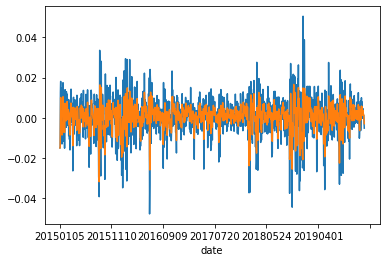

In [39]:
df.NASDAQ_1.plot()
df.NASDAQ_ema_1.plot()

In [44]:
splits = TimeSeriesSplit(n_splits=10)


X=df.dropna()[ts_feature_ls_NASDAQ].values
y=df.dropna().NASDAQ_Y.values.reshape(-1,1)


e_NASDAQ=[]
for train_index, test_index in splits.split(X):
    X_train=X[train_index]
    y_train=y[train_index]
    X_test=X[test_index]
    y_test=y[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    
    e_NASDAQ.append(mean_squared_error(y_test,reg.predict(X_test)))

print(sum(e_NASDAQ))


X=df.dropna()[ts_feature_ls_HS300].values
y=df.dropna().HS300_Y.values.reshape(-1,1)
e_HS300=[]

for train_index, test_index in splits.split(X):
    X_train=X[train_index]
    y_train=y[train_index]
    X_test=X[test_index]
    y_test=y[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    e_HS300.append(mean_squared_error(y_test,reg.predict(X_test)))

print(sum(e_HS300))

#0.0010682335411004822
#0.0024755621991366297


0.0010740398049062453
0.0024791686021989716


In [45]:
f'{(0.0010682335411004822-0.0010740398049062453)/0.0010740398049062453}%',f'{(0.0024755621991366297-0.0024791686021989716)/0.0024755621991366297}%'

('-0.005406004301926228%', '-0.0014568016362504204%')

# 4 Causality

In [48]:
grangercausalitytests(df[['NASDAQ','HS300']],maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3892  , p=0.2445  , df_denom=1170, df_num=3
ssr based chi2 test:   chi2=4.1925  , p=0.2414  , df=3
likelihood ratio test: chi2=4.1850  , p=0.2422  , df=3
parameter F test:         F=1.3892  , p=0.2445  , df_denom=1170, df_num=3


{3: ({'ssr_ftest': (1.3891813563355402, 0.24450259039153135, 1170.0, 3),
   'ssr_chi2test': (4.192478093351105, 0.24141605043553, 3),
   'lrtest': (4.185028966547179, 0.24216505020016718, 3),
   'params_ftest': (1.3891813563355517, 0.24450259039153135, 1170.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [50]:
grangercausalitytests(df[['HS300','NASDAQ']],maxlag=[3])[3][0]['params_ftest']


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.5661 , p=0.0000  , df_denom=1170, df_num=3
ssr based chi2 test:   chi2=46.9778 , p=0.0000  , df=3
likelihood ratio test: chi2=46.0645 , p=0.0000  , df=3
parameter F test:         F=15.5661 , p=0.0000  , df_denom=1170, df_num=3


(15.566142356631426, 6.224145375755997e-10, 1170.0, 3.0)

In [54]:
maxlag=[1,2,3]
causality_features=[]
for lag in maxlag:
    df[f'NASDAQ_by_HS300_{lag}']=0
    df[f'HS300_by_NASDAQ_{lag}']=0
    causality_features.append(f'NASDAQ_by_HS300_{lag}')
    causality_features.append(f'HS300_by_NASDAQ_{lag}')

for i in range(20,len(df)):
    gc_results_NASDAQ_by_HS300=grangercausalitytests(df.iloc[i-20:i][['NASDAQ','HS300']], maxlag=maxlag,verbose=0)
    gc_results_HS300_by_NASDAQ=grangercausalitytests(df.iloc[i-20:i][['HS300','NASDAQ']], maxlag=maxlag,verbose=0)
    
    for lag in maxlag:
        df[f'NASDAQ_by_HS300_{lag}'].iloc[i]=gc_results_NASDAQ_by_HS300[lag][0]['params_ftest'][1]
        df[f'HS300_by_NASDAQ_{lag}'].iloc[i]=gc_results_HS300_by_NASDAQ[lag][0]['params_ftest'][1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


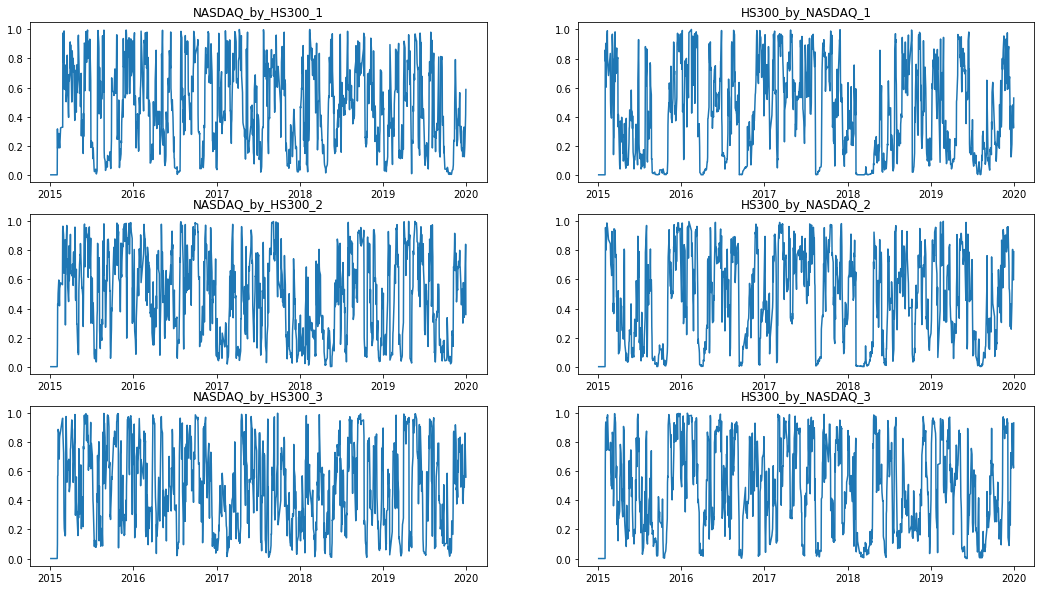

In [55]:
fig,ax=plt.subplots(3,2,figsize=(18,10))

ax[0][0].plot(pd.to_datetime(df.index),df[f'NASDAQ_by_HS300_1'].values)
ax[0][0].set_title(f'NASDAQ_by_HS300_1')

ax[1][0].plot(pd.to_datetime(df.index),df[f'NASDAQ_by_HS300_2'].values)
ax[1][0].set_title(f'NASDAQ_by_HS300_2')

ax[2][0].plot(pd.to_datetime(df.index),df[f'NASDAQ_by_HS300_3'].values)
ax[2][0].set_title(f'NASDAQ_by_HS300_3')


ax[0][1].plot(pd.to_datetime(df.index),df[f'HS300_by_NASDAQ_1'].values)
ax[0][1].set_title(f'HS300_by_NASDAQ_1')

ax[1][1].plot(pd.to_datetime(df.index),df[f'HS300_by_NASDAQ_2'].values)
ax[1][1].set_title(f'HS300_by_NASDAQ_2')

ax[2][1].plot(pd.to_datetime(df.index),df[f'HS300_by_NASDAQ_3'].values)
ax[2][1].set_title(f'HS300_by_NASDAQ_3')

plt.show()

In [56]:
splits = TimeSeriesSplit(n_splits=10)

X=df.dropna()[ts_feature_ls_HS300+['NASDAQ_0']].values
y=df.dropna().NASDAQ_Y.values.reshape(-1,1)

e_NASDAQ=[]
for train_index, test_index in splits.split(X):
    X_train=X[train_index]
    y_train=y[train_index]
    X_test=X[test_index]
    y_test=y[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    
    e_NASDAQ.append(mean_squared_error(y_test,reg.predict(X_test)))

print(sum(e_NASDAQ))


X=df.dropna()[ts_feature_ls_NASDAQ+['HS300_0']].values
y=df.dropna().HS300_Y.values.reshape(-1,1)
e_HS300=[]

for train_index, test_index in splits.split(X):
    X_train=X[train_index]
    y_train=y[train_index]
    X_test=X[test_index]
    y_test=y[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    e_HS300.append(mean_squared_error(y_test,reg.predict(X_test)))

print(sum(e_HS300))

#0.0010682335411004822
#0.0024755621991366297

0.0010769305115366542
0.0023558970361484887


In [57]:
f'{(0.0010682335411004822-0.0010769305115366542)/0.0010740398049062453}%',f'{(0.0024755621991366297-0.0023558970361484887)/0.0024755621991366297}%'

('-0.008097437726650388%', '0.04833858063831925%')